# Trabalho Prático 1

Thiago V. de A. Silva (thiagovieiraas [at] gmail [dot] com)



## Importing Modules
On this work, I use:
* 'keras' for building the models,
* 'scikit-learn' to aid me on the evaluation task of the models built,
* and 'pandas' for some data analysis.

Note: The random seed is always 42.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import optimizers

from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_val_score

from keras.wrappers.scikit_learn import KerasClassifier
%matplotlib inline


np.random.seed(42)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Loading the Dataset

In [2]:
data = pd.read_csv('data.csv', header=None, sep=',')

Y = data[data.columns[0]]
X = data[data.columns[1:]]

Y = to_categorical(Y)

print("Number of samples:", X.shape[0])
print("Number of features:", X.shape[1])

Number of samples: 5000
Number of features: 784


## Plotting the Images

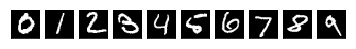

In [36]:
f, pltarr = plt.subplots(1, 10)
for i in range(10):
    img_matrix = data[data[0]==i].iloc[0].values[1:].reshape(28, 28)
    pltarr[i].imshow(img_matrix, cmap='gray', aspect='equal')
    pltarr[i].set_xticks([])
    pltarr[i].set_yticks([])
plt.show()

## Creating Auxiliary Classes

In order to use Keras + scikit_learn it's necessary to define functions (or classes) to build the models, hence that's what I'm going to do now...

Below, there are two classes.
The first one is the *Classifier*. This class was created just to allow me use some callbacks. On the Classifier class I just overwrote the constructor and the get_params function of KerasClassifier. I decided to implement this class mostly to ease the integration between scikit and keras.<br/>

The second class is the *ML_Model*. This class serves to build a new model given two parameters:
<ol>
<li>Learning Rate,</li>
<li>Number of nodes on the hidden layer.</li>
</ol>

On this work, I fixed the first activation function as the *sigmoid* function, and the second as the *softmax*.
I also make sure that no decay, momentum or Nesterov Momentum is used on the model.

The loss function used is the categorial cross entropy, that's equivalent with the function presented by the professor:
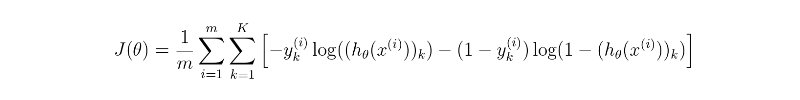

In [11]:
class Classifier(KerasClassifier):
    def __init__(self, build_fn=None, callbacks=[], **sk_params):
        self.build_fn = build_fn
        self.callbacks = callbacks
        self.sk_params = sk_params
        self.sk_params['callbacks'] = callbacks
    
    def get_params(self, deep=True):
        res = copy.deepcopy(self.sk_params)
        res.update({'build_fn': self.build_fn, 'callbacks': self.callbacks})
        return res
    


class ML_Model():
    def __init__(self, plr=0.5, phl=25):
        self.lr_ = plr
        self.hl_ = phl
        
    
    def __call__(self):
        # Building model with keras
        model = Sequential()
        model.add(Dense(self.hl_, input_dim=784, activation='sigmoid'))
        model.add(Dense(10, activation='softmax'))

        sgd = optimizers.SGD(lr=self.lr_, decay=0.0, momentum=0.0, nesterov=False)

        # Compiling the model...
        model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

        return model

TODO:<br/>
O documento a ser entregue deverá apresentar o resultado de seus experimentos. Ou seja, deverá apresentar discussão da variação do número de unidades na camada oculta para cada um dos três algoritmos de cálculo de gradiente. Você deverá apresentar gráficos mostrando a convergência do erro empírico para cada situação (unidades na camada oculta, algoritmo de cálculo do gradiente, taxa de aprendizado). Você deverá deixar claras todas as hipóteses que julgar serem pertinentes.

In [13]:
# Setting a early stopping callback...
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=0, mode='auto')
n_epochs = 100

for b_size in [1, 10, 50, len(Y)]:
    for n_hl in [25, 50, 100]:
        for p_lr in [0.5, 1, 10]:
            kmodel = Classifier(build_fn=ML_Model(p_lr, n_hl), epochs=n_epochs, batch_size=b_size, verbose=0,
                                     validation_split=0.16)
            
            kfold = KFold(n_splits=5, shuffle=True, random_state=42)
            print('Batch size:', b_size, ', Hidden Layers:', n_hl, ', Learning Rate:', p_lr)
            results = cross_val_score(kmodel, X, Y, cv=kfold, n_jobs=-1)
            print(results.mean(), results.std())
            print('')

Batch size: 1 , Hidden Layers: 25 , Learning Rate: 0.5
0.10779999999999998 0.013818827736099756

Batch size: 1 , Hidden Layers: 25 , Learning Rate: 1


Process ForkPoolWorker-129:
Process ForkPoolWorker-128:
Process ForkPoolWorker-126:


KeyboardInterrupt: 

\- Thiago Vieira de Alcantara Silva <br>
2017719891